In [2]:
import nltk
from nltk import sent_tokenize, pos_tag
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment.util import mark_negation
from string import punctuation
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Sentiment Scoring Using SentiWordNet

In [3]:
def penn_to_wn(tag):
    """
        Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None


In [4]:
def get_sentiment_score(text):
    """
        This method returns the sentiment score of a given text using SentiWordNet sentiment scores.
        input: text
        output: numeric (double) score, >0 means positive sentiment and <0 means negative sentiment.
    """  
    total_score = 0
    raw_sentences = sent_tokenize(text)
    
    for sentence in raw_sentences:

        sent_score = 0
        sentence = str(sentence)
        sentence = sentence.replace('<br />', ' ').translate(str.maketrans('','', punctuation)).lower
        tokens = TreebankWordTokenizer().tokenize(text)
        tags = pos_tag(tokens)
        for word, tag in tags:
            wn_tag = penn_to_wn(tag)
            if not wn_tag:
                continue
            lemma = WordNetLemmatizer().lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            sent_score += swn_synset.pos_score() - swn_synset.neg_score()


    total_score = total_score + (sent_score / len(tokens))

    
    return (total_score / len(raw_sentences)) * 100


In [5]:
reviews = pd.read_csv("small_corpus.csv")

In [6]:
reviews.shape

(4500, 2)

In [7]:
reviews = reviews.dropna(subset=['reviewText'])

In [8]:
reviews.shape

(4500, 2)

In [9]:
reviews['swn_score'] = reviews['reviewText'].apply(lambda text : get_sentiment_score(text))

In [10]:
reviews.head(5)

,reviewText,overall,swn_score
0,Best gift ever!,5,25.000000
1,"A tank with attitude! what else is there to say, lol",5,0.480769
2,"My 9yr old granddaughter LOVES Zelda games and when I gave her this one, she was ecstatic! She plays all the games whenever she has the chance (2 hrs a day max).",5,2.027027
3,"Deus Ex has a nasty habit of pulling you into its world when you least expect it to, leaving your concerns of the real world behind (such as your job, eating, your spouse) as you slip on the trenchcoat of UNATCO operative JC Denton.\nThe game plays out like some crazy episode of the X-Files, with conspiracies flying at the player from all directions. The very basic premise of Deus Ex has agent JC Denton investigating a mysterious plague that has engulfed the world in the near future. Denton is augmented with nano-technology, which allows for the development of specific abilities, such as regeneration of health or increased strength. Through the course of the game the player can decide how to grow the character. He can be a ruthless killing machine, an expert in all weapons, or he can operate via stealth, breaking into computer systems or installations silently to accomplish his goals.\nThe conspiracies unfold via conversations with other characters, such as Denton's fellow UNATCO agent and brother, Paul; e-mails and other electronic communications. In the world of Deus Ex, all is not what it seems, as JC Denton soon learns.\nOne of the best aspects of the game is that it can be played as the player sees fit. With each situation JC encounters, there are many different ways to solve the problem. This also results in high replayability, as you can start the game over and try it with different tactics.\nWith many places selling Deus Ex at a discount, now is the perfect time to engulf yourself in the world of Deus Ex.",5,0.025318
4,"a great deal if the codes work, and you can buy for less than $20",5,-2.941176


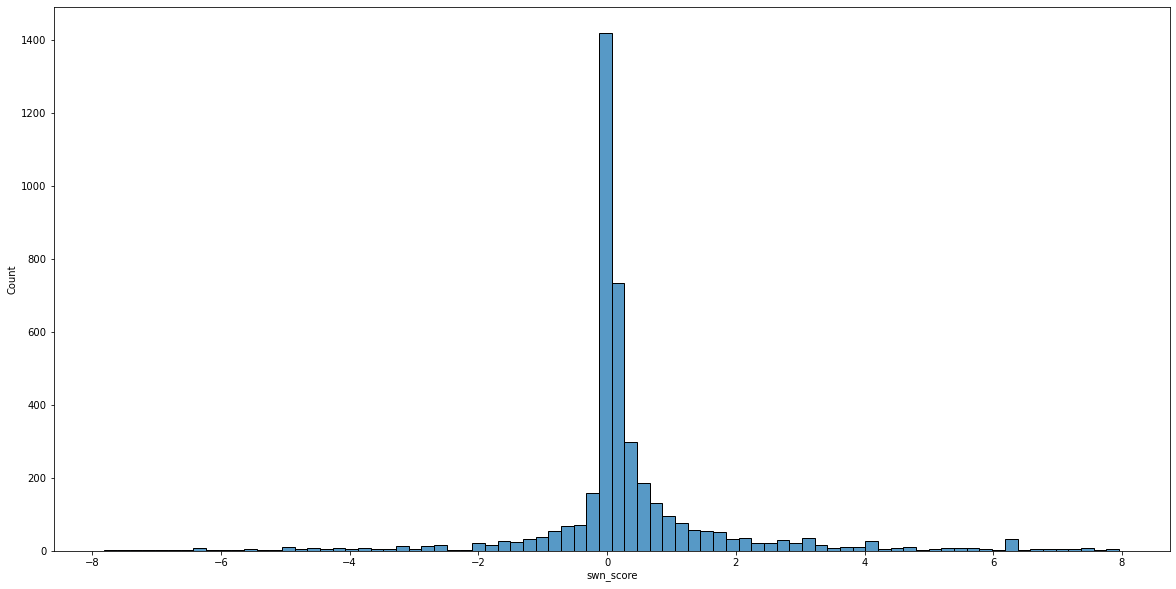

In [13]:
fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
sns.histplot(x='swn_score', data=reviews.query("swn_score < 8 and swn_score > -8"), ax=ax, bins=80)
plt.show()

In [14]:
reviews['swn_sentiment'] = reviews['swn_score'].apply(lambda x: "positive" if x > 1 else ("negative" if x < 0.5 else "neutral"))

In [15]:
reviews.head(5)

,reviewText,overall,swn_score,swn_sentiment
0,Best gift ever!,5,25.000000,positive
1,"A tank with attitude! what else is there to say, lol",5,0.480769,negative
2,"My 9yr old granddaughter LOVES Zelda games and when I gave her this one, she was ecstatic! She plays all the games whenever she has the chance (2 hrs a day max).",5,2.027027,positive
3,"Deus Ex has a nasty habit of pulling you into its world when you least expect it to, leaving your concerns of the real world behind (such as your job, eating, your spouse) as you slip on the trenchcoat of UNATCO operative JC Denton.\nThe game plays out like some crazy episode of the X-Files, with conspiracies flying at the player from all directions. The very basic premise of Deus Ex has agent JC Denton investigating a mysterious plague that has engulfed the world in the near future. Denton is augmented with nano-technology, which allows for the development of specific abilities, such as regeneration of health or increased strength. Through the course of the game the player can decide how to grow the character. He can be a ruthless killing machine, an expert in all weapons, or he can operate via stealth, breaking into computer systems or installations silently to accomplish his goals.\nThe conspiracies unfold via conversations with other characters, such as Denton's fellow UNATCO agent and brother, Paul; e-mails and other electronic communications. In the world of Deus Ex, all is not what it seems, as JC Denton soon learns.\nOne of the best aspects of the game is that it can be played as the player sees fit. With each situation JC encounters, there are many different ways to solve the problem. This also results in high replayability, as you can start the game over and try it with different tactics.\nWith many places selling Deus Ex at a discount, now is the perfect time to engulf yourself in the world of Deus Ex.",5,0.025318,negative
4,"a great deal if the codes work, and you can buy for less than $20",5,-2.941176,negative


In [16]:
reviews['swn_sentiment'].value_counts()

negative    3219
positive     926
neutral      355
Name: swn_sentiment, dtype: int64

<AxesSubplot:xlabel='overall', ylabel='count'>

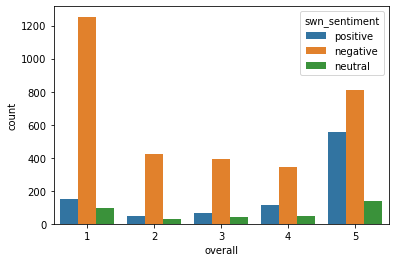

In [17]:
sns.countplot(x='overall', hue='swn_sentiment', data=reviews)

<AxesSubplot:xlabel='swn_sentiment', ylabel='overall'>

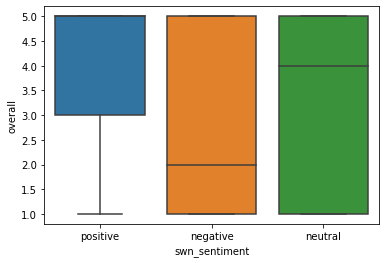

In [18]:
sns.boxplot(x='swn_sentiment', y='overall', data = reviews)

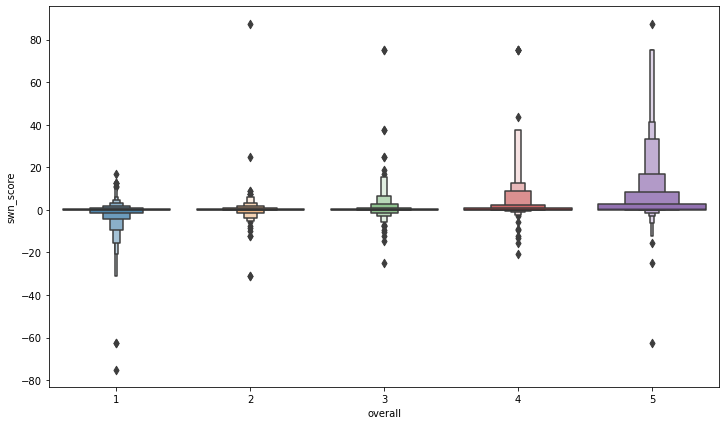

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12,7))
sns.boxenplot(x='overall', y='swn_score', data=reviews, ax=ax)
plt.show()

In [20]:
reviews['true_sentiment'] = \
    reviews['overall'].apply(lambda x: "positive" if x>=4 else ("neutral" if x==3 else "negative"))

In [21]:
y_swn_pred, y_true = reviews['swn_sentiment'].tolist(), reviews['true_sentiment'].tolist()

In [22]:
cm = confusion_matrix(y_swn_pred, y_true)

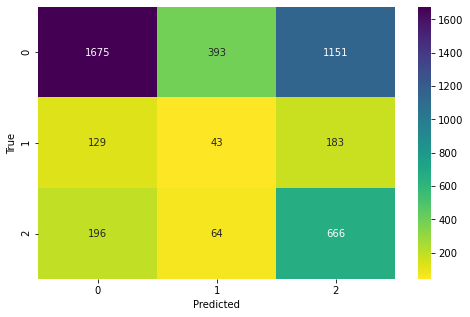

In [23]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,5))
sns.heatmap(cm, cmap='viridis_r', ax=ax, annot=True, fmt='d')
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

## Calculating score

In [24]:
tp, tn, fp, fn = 1675, 43+183+64+666, 393+1151, 129+196

In [25]:
recall = tp / (tp+fn)
specifity = tn / (tn + fp)
precision = tp / (tp + fp)
f1 = (2*tp) / (2*tp + fp + fn)

In [26]:
print(f"recall: {recall}\nprecission: {precision}\nf1 score: {f1}")

recall: 0.8375
precission: 0.5203479341410376
f1 score: 0.6418854186625791


# Sentiment Scoring Model Using NLTK Opinion Lexicon

In [27]:
import nltk
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize, sent_tokenize

In [28]:
pos_words = list(opinion_lexicon.positive())
neg_words = list(opinion_lexicon.negative())

In [29]:
def get_sentiment_score_oplex(text):
    
    """
        This method returns the sentiment score of a given text using nltk opinion lexicon.
        input: text
        output: numeric (double) score, >0 means positive sentiment and <0 means negative sentiment.
    """    
    total_score = 0

    raw_sentences = sent_tokenize(text)
    
    for sentence in raw_sentences:

        sent_score = 0     
        sentence = str(sentence)
        sentence = sentence.replace("<br />"," ").translate(str.maketrans('','',punctuation)).lower()
        tokens = TreebankWordTokenizer().tokenize(text)
        for token in tokens:
            sent_score = sent_score + 1 if token in pos_words else (sent_score - 1 if token in neg_words else sent_score)
        total_score = total_score + (sent_score / len(tokens))

    
    return total_score

In [30]:
reviews['oplex_sentiment_score'] = reviews['reviewText'].apply(lambda x: get_sentiment_score_oplex(x))

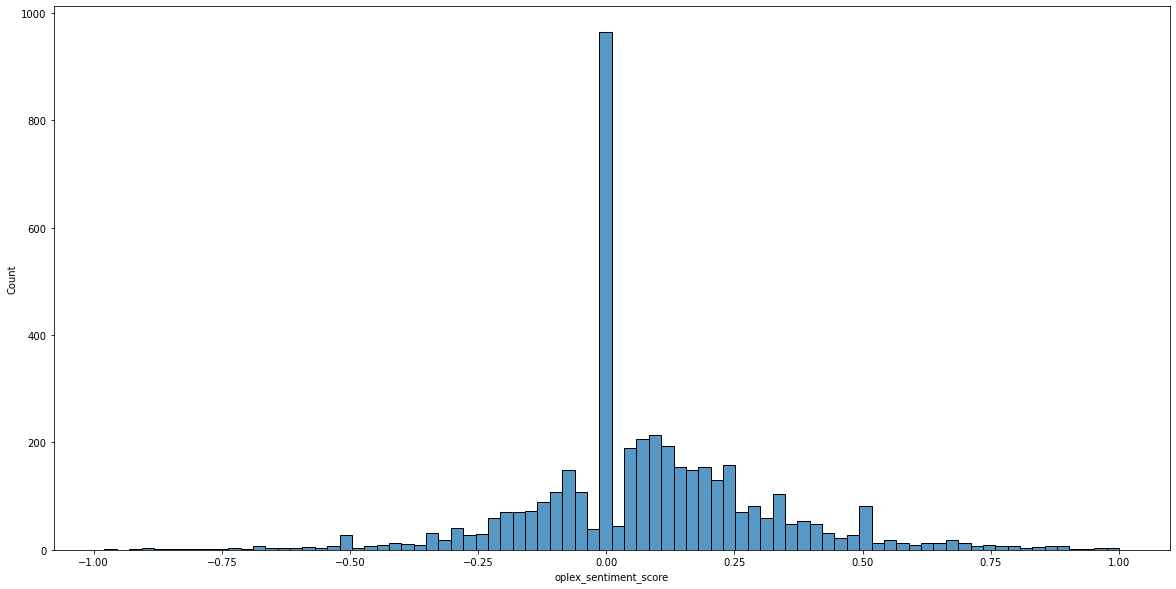

In [31]:
fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
sns.histplot(x='oplex_sentiment_score',\
             data=reviews.query("oplex_sentiment_score < 1 and oplex_sentiment_score>-1"), ax=ax)
plt.show()

In [32]:
reviews['oplex_sentiment'] = (reviews['oplex_sentiment_score']
                              .apply(lambda x: "positive" if x > 0.1 else ("negative" if x < 0 else "neutral")))


In [33]:
reviews['oplex_sentiment'].value_counts()

positive    1863
neutral     1573
negative    1064
Name: oplex_sentiment, dtype: int64

<AxesSubplot:xlabel='overall', ylabel='count'>

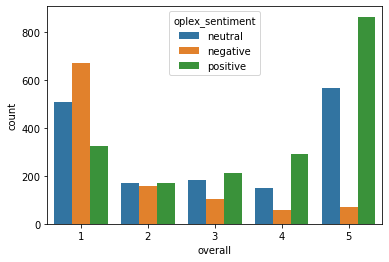

In [34]:
sns.countplot(x='overall', hue='oplex_sentiment', data=reviews)

<AxesSubplot:xlabel='oplex_sentiment', ylabel='overall'>

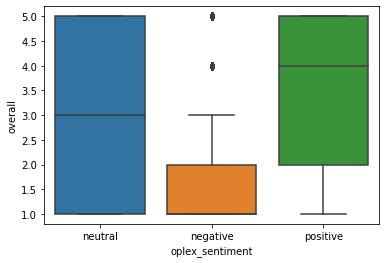

In [35]:
sns.boxplot(x='oplex_sentiment', y='overall', data = reviews)

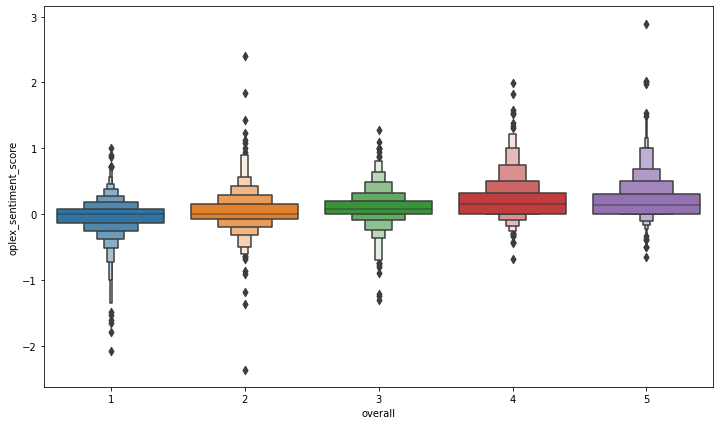

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12,7))
sns.boxenplot(y='oplex_sentiment_score', x='overall', data=reviews, ax=ax)
plt.show()

## Calculating score

In [37]:
y_oplex_pred = reviews['oplex_sentiment'].tolist()

In [38]:
cm_oplex = confusion_matrix(y_oplex_pred, y_true)

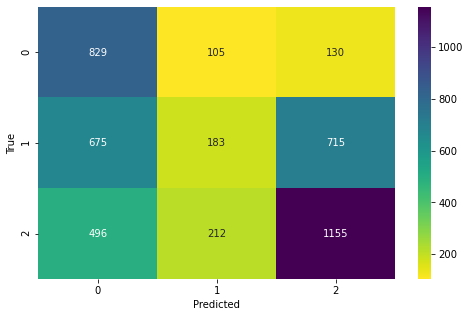

In [39]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,5))
sns.heatmap(cm_oplex, cmap='viridis_r', ax=ax, annot=True, fmt='d')
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [40]:
tp, tn, fp, fn = cm_oplex[0][0], (cm_oplex[1][1]+cm_oplex[1][2]+
                                  cm_oplex[2][1]+cm_oplex[2][2]), cm_oplex[1][0]+cm_oplex[2][0], cm_oplex[0][1]+cm_oplex[0][2]

In [41]:
recall = tp / (tp+fn)
specifity = tn / (tn+fp)
precision = tp/(tp+fp)
f1 = (2*tp) / (2*tp + fp + fn)

print(f"recall: {recall}\nprecission: {precision}\nf1 score: {f1}")

recall: 0.7791353383458647
precission: 0.4145
f1 score: 0.5411227154046997


# Results

The results of the study showed that the accuracy of the estimate `SentiWordNet precission 0.5203` > `NLTK Opinion Lexiconprecission: 0.4145 `. Hence we have f1 score `0.6418` vs `0.5411`. 

Model base on SentiWordNet showed the best performance